In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.style.use('/Users/mayafishbach/Desktop/gw-pop-numpyro/src/gw_pop_numpyro/maya.mplstyle')

import numpy as np

import jax.numpy as jnp

import h5py

import delay_time_helper

import gw_pop_numpyro

from gw_pop_numpyro import plot_helper, config

In [2]:
import seaborn as sns
sns.set_palette('colorblind')

In [3]:
tmax = config.cosmo_dict["lookback_time"](config.zmax)

In [4]:
print(tmax/1e3)

13.619099


In [5]:
seed = 1148

In [6]:
color_dict = {'default' : sns.color_palette()[2], 'shallower' : sns.color_palette()[0], 'shallow' : sns.color_palette()[3],
             'prior' : sns.color_palette()[1], 'merger' : sns.color_palette()[7]
             }

### Delay time intuition

Text(0, 0.5, 'Maximum $z_\\mathrm{form}$')

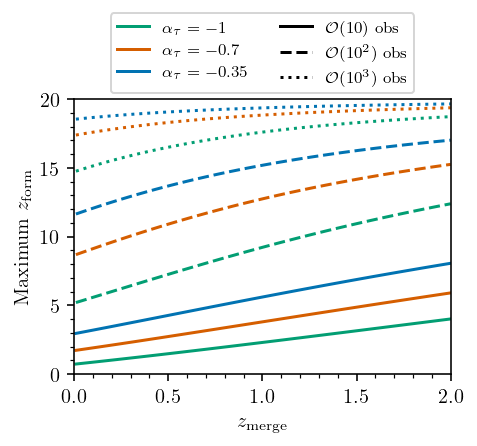

In [7]:
def calculate_z_f_quantile(z_m, q, tmin, alpha):
    
    t_m = config.cosmo_dict["lookback_time"](z_m)
    
    #truncate and renormalize formation times to respect hard limit at tmax
    td_q = delay_time_helper.inverse_cdf_powerlaw(q, tmin = tmin, alpha = alpha, tmax = tmax - t_m)
        
    t_f = t_m + td_q
    
    z_f = config.cosmo_dict["z_at_lookback_time"](t_f)
    
    return z_f

zs_m = jnp.linspace(0.01, 2, 100)

qs = [0.9, 0.99, 0.999]

label_q = [r'$\mathcal{O}(10)$ obs', r'$\mathcal{O}(10^2)$ obs', r'$\mathcal{O}(10^3)$ obs']

alphas = [-1, -0.7, -0.35]

colors = [color_dict["default"], color_dict["shallow"], color_dict["shallower"]]

label_al = [r'$\alpha_\tau = -1$', r'$\alpha_\tau = -0.7$', r'$\alpha_\tau = -0.35$']

tmin = 10

lss = ['-', '--', ':']

for i, q in enumerate(qs):
    
    for j, al in enumerate(alphas):
        
        zs_f = calculate_z_f_quantile(zs_m, q, tmin, al)
        
                    
        label = None
        
        if i == 0:
            
                
                label = label_al[j]
            
            
        #elif j == 0:
            
        #    label = label_q[i]
            
            
        plt.plot(zs_m, zs_f, ls = lss[i], linewidth = 1.5, color = colors[j], label = label)
            

for i in range(3):
    plt.plot(-zs_m, -zs_f, ls = lss[i], linewidth = 1.5, color = 'k', label = label_q[i])
            
plt.xlim(0, 2)
plt.ylim(0, 20)
plt.legend(bbox_to_anchor=(0.5, 1.34), loc='upper center', fancybox = True, frameon = True, ncol = 2)
plt.xlabel(r'$z_\mathrm{merge}$')
plt.ylabel('Maximum $z_\mathrm{form}$')

#plt.savefig("figures/zform-quantiles-v-zmerge.pdf", bbox_inches = 'tight')

#plt.savefig("figures/zform-quantiles-v-zmerge.png", dpi = 300, bbox_inches = 'tight')

### Oldest black holes in GWTC-3

In [8]:
obs_samps_allparams = dict()

with h5py.File('reweighted_PE_GWTC3-defaultpop.h5', 'r') as inp:
    for key in inp.keys():
        obs_samps_allparams[key] = jnp.array(inp[key])

In [9]:
delay_time_helper.add_formation_tL(obs_samps_allparams, tmin = 10, seed = seed)
obs_samps_allparams["formation_redshift"] = config.cosmo_dict["z_at_lookback_time"](obs_samps_allparams["formation_lookback_time"])

In [10]:
delay_time_helper.add_formation_tL(obs_samps_allparams, tmin = 10, alpha = -0.35, seed = seed)
obs_samps_allparams["formation_redshift_al035"] = config.cosmo_dict["z_at_lookback_time"](obs_samps_allparams["formation_lookback_time"])

/opt/anaconda3/envs/jaxpop/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:3266: UserWarning: 'kind' argument to argsort is ignored; only 'stable' sorts are supported.
  warnings.warn("'kind' argument to argsort is ignored; only 'stable' sorts "


Text(0, 0.5, '$N(\\mathrm{obs} > z)$')

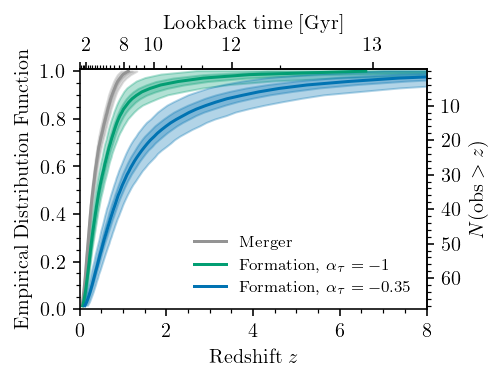

In [11]:
fig, ax = plt.subplots(constrained_layout = True)
lines_zm = plot_helper.plot_cdf_bands(ax, obs_samps_allparams["redshift"], plot_kwargs = dict(label = 'Merger', color = color_dict["merger"]), color = color_dict["merger"], ret_lines = True)
lines_zf_alpha1 = plot_helper.plot_cdf_bands(ax, obs_samps_allparams["formation_redshift"], plot_kwargs = dict(label = r'Formation, $\alpha_\tau = -1$', color = color_dict["default"]), color = color_dict["default"], ret_lines = True)
lines_zf_alpha035 = plot_helper.plot_cdf_bands(ax, obs_samps_allparams["formation_redshift_al035"], plot_kwargs = dict(label = r'Formation, $\alpha_\tau = -0.35$', color = color_dict["shallower"]), color = color_dict["shallower"], ret_lines = True)



ax.set_ylim(0,1.01)
ax.set_xlim(0, 8)

ax.set_xlabel("Redshift $z$")
ax.set_ylabel("Empirical Distribution Function")

plt.legend(loc = 'lower right')

timeax = ax.secondary_xaxis('top', functions=(config.cosmo_dict["lookback_time"], config.cosmo_dict["z_at_lookback_time"]))
timeax.set_xticks(ticks = [0, 2000, 8000, 10000, 12000, 13000, 13250], labels = ['', '2', '8', '10', '12', '13', '13.25'])

timeax.set_xlabel('Lookback time [Gyr]')

Ndetax = ax.secondary_yaxis('right', functions = (lambda x: (1 - x)*69, lambda x: 1 - x/69))
Ndetax.set_yticks(ticks = [10,20,30,40,50,60])

Ndetax.set_ylabel(r'$N(\mathrm{obs} > z)$')

#plt.savefig("figures/EDF_zmerge_zform_GWTC3.pdf", bbox_inches = 'tight')
#plt.savefig("figures/EDF_zmerge_zform_GWTC3.png", dpi = 300, bbox_inches = 'tight')

(-1.5, -0.25)

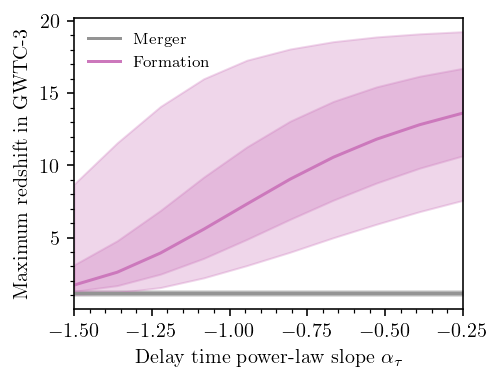

In [12]:
alphas = np.linspace(-1.5, -0.25, 10)

max_formation_redshifts = np.zeros((2000, len(alphas)))

for i, al in enumerate(alphas):
    
    formation_redshift = delay_time_helper.calculate_formation_redshift(obs_samps_allparams, tmin = 10, alpha = al, seed = seed)
    
    max_formation_redshifts[:, i] = np.max(formation_redshift, axis = -1)
    

fig, ax = plt.subplots(constrained_layout=True)

ax.plot(alphas, np.ones_like(alphas) * np.percentile(lines_zm[:,-1], 50, axis = 0), color = color_dict["merger"], label = 'Merger')
ax.fill_between(alphas, np.percentile(lines_zm[:,-1], 5, axis = 0),  np.percentile(lines_zm[:,-1], 95, axis = 0), alpha = 0.3, color = color_dict["merger"])
ax.fill_between(alphas, np.percentile(lines_zm[:,-1], 25, axis = 0),  np.percentile(lines_zm[:,-1], 75, axis = 0), alpha = 0.3, color = color_dict["merger"])

plot_helper.plot_bands(ax, alphas, max_formation_redshifts, plot_kwargs = dict(label = 'Formation'), alpha = 0.3, color = sns.color_palette()[4])



plt.legend(loc = 'upper left')

ax.set_xlabel(r'Delay time power-law slope $\alpha_\tau$')

ax.set_ylabel('Maximum redshift in GWTC-3')

ax.set_xlim(-1.5, -0.25)

#plt.savefig("figures/max_zs_GWTC3_valpha.pdf", bbox_inches = 'tight')
#plt.savefig("figures/max_zs_GWTC3_valpha.png", dpi = 300, bbox_inches = 'tight')

This is the truncated/ renormalized versions of the formation redshifts posteriors, truncated at zmax. 
We do not directly use these when fitting for the formation rate, but assume the same maximum delay time for all events, and then set the formation rate to zero above zmax. 
This difference does not matter much right now because (a) we probably don't have any events that formed at zmax and (b) the formation rate probably drops gradually to zero near zmax, and we are fixing zmax. 

In [13]:
formation_redshift_alpha15 = delay_time_helper.calculate_formation_redshift(obs_samps_allparams, tmin = 10, alpha = -1.5, seed = seed)

formation_redshift_alpha07 = delay_time_helper.calculate_formation_redshift(obs_samps_allparams, tmin = 10, alpha = -0.7, seed = seed)

formation_redshift_alpha35 = delay_time_helper.calculate_formation_redshift(obs_samps_allparams, tmin = 10, alpha = -0.35, seed = seed)

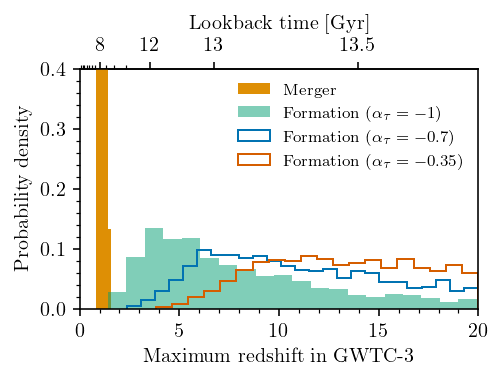

In [14]:
fig, ax = plt.subplots(constrained_layout=True)

ax.hist(lines_zm[:,-1], bins = 5, density = True, label = 'Merger', color = sns.color_palette()[1])
ax.hist(lines_zf_alpha1[:,-1], bins = 20, alpha = 0.5, density = True, label = r'Formation ($\alpha_\tau = -1$)', color = sns.color_palette()[2])
ax.hist(np.max(formation_redshift_alpha07, axis = -1), bins = 25, alpha = 1, density = True, histtype = 'step', label = r'Formation ($\alpha_\tau = -0.7$)', color = sns.color_palette()[0])
ax.hist(np.max(formation_redshift_alpha35, axis = -1), bins = 20, alpha = 1, density = True, histtype = 'step', label = r'Formation ($\alpha_\tau = -0.35$)', color = sns.color_palette()[3])

ax.set_ylim(0, 0.4)
ax.set_xlim(0, 20)

timeax = ax.secondary_xaxis('top', functions=(config.cosmo_dict["lookback_time"], config.cosmo_dict["z_at_lookback_time"]))
timeax.set_xticks(ticks = [8000, 12000, 13000, 13500], labels = ['8', '12', '13', '13.5'])

timeax.set_xlabel('Lookback time [Gyr]')

ax.set_xlabel("Maximum redshift in GWTC-3")
ax.set_ylabel("Probability density")

plt.legend(loc = 'upper right')


#plt.savefig("figures/max_zmerge_zform_GWTC3.pdf", bbox_inches = 'tight')
#plt.savefig("figures/max_zmerge_zform_GWTC3.png", dpi = 300, bbox_inches = 'tight')

In [15]:
print('maximum merger redshift ', plot_helper.median_pm_symmetric(lines_zm[:,-1]))
print('maximum formation redshift, alpha = -1 ', plot_helper.median_pm_symmetric(lines_zf_alpha1[:,-1]))
print('maximum formation redshift, alpha = -1.5 ', plot_helper.median_pm_symmetric(np.max(formation_redshift_alpha15, axis = -1)))
print('maximum formation redshift, alpha = -0.7 ', plot_helper.median_pm_symmetric(np.max(formation_redshift_alpha07, axis = -1)))
print('maximum formation redshift, alpha = -0.35 ', plot_helper.median_pm_symmetric(np.max(formation_redshift_alpha35, axis = -1)))

maximum merger redshift  1.1^{+0.2}_{-0.2}
maximum formation redshift, alpha = -1  6.6^{+10.2}_{-3.9}
maximum formation redshift, alpha = -1.5  1.7^{+7.0}_{-0.7}
maximum formation redshift, alpha = -0.7  10.2^{+8.2}_{-5.5}
maximum formation redshift, alpha = -0.35  13.1^{+6.1}_{-6.0}


In [16]:
#how many events have formation redshifts above 2?
n_above_2 = np.zeros(1000)

for i in range(1000):
    x = (np.arange(69)[::-1])[lines_zf_alpha1[i,:] >= 2]
    if len(x) > 0:
        n_above_2[i] = x[0]

        
print(f"We have observed an event that formed above redshift 2 with credibility {1 - sum(n_above_2 == 0)/len(n_above_2)}")
print(f"The number of events that formed above redshift 2 is {plot_helper.median_pm_symmetric(n_above_2)}")



n_above_1 = np.zeros(1000)

for i in range(1000):
    x = (np.arange(69)[::-1])[lines_zf_alpha1[i,:] >= 1]
    if len(x) > 0:
        n_above_1[i] = x[0]
        
print(f"We have observed an event that formed above redshift 1 with credibility {1 - sum(n_above_1 == 0)/len(n_above_1)}")
print(f"The number of events that formed above redshift 1 is {plot_helper.median_pm_symmetric(n_above_1)}")

We have observed an event that formed above redshift 2 with credibility 0.929
The number of events that formed above redshift 2 is 3.0^{+4.0}_{-3.0}
We have observed an event that formed above redshift 1 with credibility 1.0
The number of events that formed above redshift 1 is 11.0^{+5.0}_{-5.0}


In [17]:
print("we have observed at least one event with z > ", np.percentile(lines_zf_alpha1[:,-1], 10), "with 90\% credibility")

we have observed at least one event with z >  3.205001473426819 with 90\% credibility


### Formation rate as a function of redshift inference

In [18]:
tmin = 10
alpha = -1

with h5py.File(f"formation_rate_hypersamples_plusgrid_tmin{tmin}_al{-alpha}.h5", 'r') as inp:
    Rfs = np.array(inp["Rf_posterior"])
    Rfs_prior = np.array(inp["Rf_prior"])
    tL_forms = np.array(inp["tL_forms"])
    loglikes = np.array(inp["log_likelihood"])
    

alpha = -0.35
with h5py.File(f"formation_rate_hypersamples_plusgrid_tmin{tmin}_al{-alpha}.h5", 'r') as inp:
    Rfs_al035 = np.array(inp["Rf_posterior"])
    Rfs_prior_al035 = np.array(inp["Rf_prior"])
    loglikes_al035 = np.array(inp["log_likelihood"])

alpha = -0.7
with h5py.File(f"formation_rate_hypersamples_plusgrid_tmin{tmin}_al{-alpha}.h5", 'r') as inp:
    Rfs_al07 = np.array(inp["Rf_posterior"])
    Rfs_prior_al07 = np.array(inp["Rf_prior"])
    loglikes_al07 = np.array(inp["log_likelihood"])
    


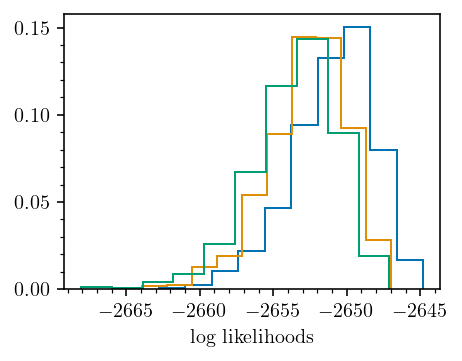

alpha = -1 max likelihood delay time model is favored to alpha = -0.7 by factor of  8.813367
alpha = -1 max likelihood delay time model is favored to alpha = -0.35 by factor of  10.104575


In [19]:
plt.hist(loglikes, histtype = 'step', density = True)
plt.hist(loglikes_al07, histtype = 'step', density = True)
plt.hist(loglikes_al035, histtype = 'step', density = True)
plt.xlabel('log likelihoods')
plt.show()

print('alpha = -1 max likelihood delay time model is favored to alpha = -0.7 by factor of ', np.exp(max(loglikes)-max(loglikes_al07)))
print('alpha = -1 max likelihood delay time model is favored to alpha = -0.35 by factor of ',np.exp(max(loglikes)-max(loglikes_al035)))

In [20]:
from gw_pop_numpyro import distributions as dist

Ts = config.cosmo_dict["age_of_universe"] - tL_forms
SFR = 0.1 * dist.rate_age(Ts/1e3, 1.34, 0.43) #in Msun Mpc^-3 yr^-1

SFR_UV = 0.037 * dist.rate_age(Ts/1e3, 1.83, 0.48) #in Msun Mpc^-3 yr^-1

xs = config.cosmo_dict["z_at_lookback_time"](tL_forms)

SFR_MF = 0.01 * (1 + xs)**2.6 / (1 + ((1 +xs) / 3.2) ** 6.2) #in Msun Mpc^-3 yr^-1

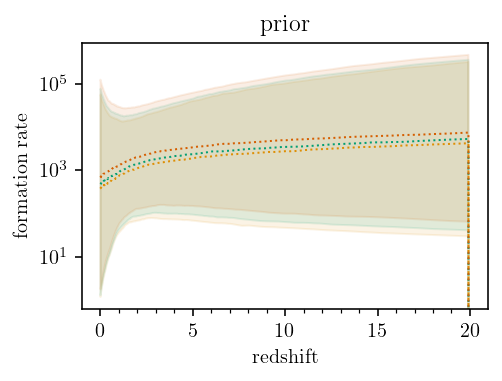

In [21]:
#check that priors are very similar
fig, ax = plt.subplots(constrained_layout=True)

plot_helper.plot_bands(ax, xs, 1e9 * Rfs_prior/ SFR_UV, bounds = [(5, 95)], plot_kwargs = dict(linewidth = 1.0, label = 'prior', ls = ':'), alpha = 0.1, color = sns.color_palette()[1])

plot_helper.plot_bands(ax, xs, 1e9 * Rfs_prior_al07 / SFR_UV, bounds = [(5, 95)], plot_kwargs = dict(linewidth = 1.0, label = 'prior', ls = ':'), alpha = 0.1, color = sns.color_palette()[2])

plot_helper.plot_bands(ax, xs, 1e9 * Rfs_prior_al035 / SFR_UV, bounds = [(5, 95)], plot_kwargs = dict(linewidth = 1.0, label = 'prior', ls = ':'), alpha = 0.1, color = sns.color_palette()[3])

ax.set_xlabel('redshift')
ax.set_ylabel('formation rate')
ax.set_title('prior')
ax.set_yscale('log')

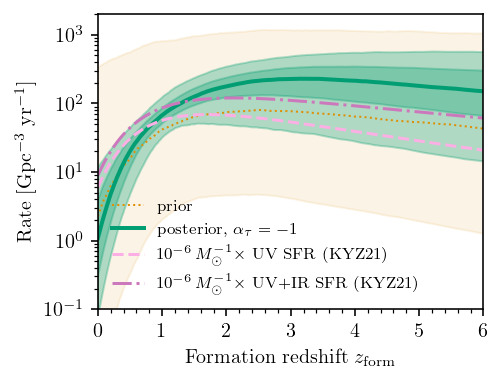

In [22]:

fig, ax = plt.subplots(constrained_layout=True)


plot_helper.plot_bands(ax, xs, 1e9 * Rfs_prior, bounds = [(5, 95)], plot_kwargs = dict(linewidth = 1.0, label = 'prior', ls = ':'), alpha = 0.1, color = color_dict["prior"])

plot_helper.plot_bands(ax, xs, 1e9 * Rfs, plot_kwargs = dict(linewidth = 2.0, label = r'posterior, $\alpha_\tau = -1$'), color = color_dict["default"])

ax.plot(xs, 1e9 * 1e-6 * SFR_UV, ls = '--', color = sns.color_palette()[6], linewidth = 1.5, label = r'$10^{-6}\,M_\odot^{-1}\times$ UV SFR (KYZ21)')

ax.plot(xs, 1e9 * 1e-6 * SFR, ls = '-.', color = sns.color_palette()[4], linewidth = 1.5, label = r'$10^{-6}\,M_\odot^{-1}\times$ UV+IR SFR (KYZ21)')

ax.set_yscale('log')

ax.set_xlim(0, 6)

ax.set_ylim(1e-1, 2e3)

ax.set_xlabel('Formation redshift $z_\mathrm{form}$')

ax.set_ylabel('Rate [Gpc$^{-3}$ yr$^{-1}$]')

plt.legend(loc = 'lower left')


#plt.savefig('figures/Rate_form_v_z_default_tau_withUV.pdf', bbox_inches = 'tight')

#plt.savefig('figures/Rate_form_v_z_default_tau_withUV.png', dpi = 300, bbox_inches = 'tight')

Text(0, 0.5, '$\\mathrm{d}N_\\mathrm{BBH}/ \\mathrm{d}M_\\mathrm{SF}\\, [M_\\odot^{-1}]$')

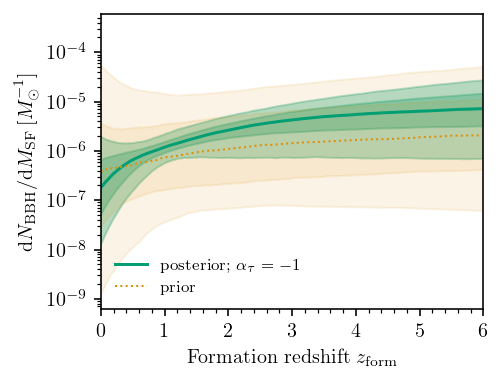

In [23]:
efficiency = Rfs / SFR_UV

efficiency_prior = Rfs_prior/ SFR_UV


fig, ax = plt.subplots(constrained_layout=True)

plot_helper.plot_bands(ax, xs, efficiency, plot_kwargs = dict(linewidth = 1.5, label = r'posterior; $\alpha_\tau = -1$'), color = sns.color_palette()[2])

plot_helper.plot_bands(ax, xs, efficiency_prior, plot_kwargs = dict(linewidth = 1.0, ls = ':', label = 'prior'), alpha = 0.1, color = sns.color_palette()[1])

plt.legend(loc = 'lower left')

ax.set_yscale('log')

ax.set_xlim(0,6)

ax.set_xlabel('Formation redshift $z_\mathrm{form}$')

ax.set_ylabel(r'$\mathrm{d}N_\mathrm{BBH}/ \mathrm{d}M_\mathrm{SF}\, [M_\odot^{-1}]$')

#plt.savefig('figures/formation_efficiency_v_redshift_default_tau.pdf', bbox_inches = 'tight')
#plt.savefig('figures/formation_efficiency_v_redshift_default_tau.png', bbox_inches = 'tight', dpi = 300)

Text(0, 0.5, '$\\mathrm{d}N_\\mathrm{BBH}/ \\mathrm{d}M_\\mathrm{SF}\\, [M_\\odot^{-1}]$')

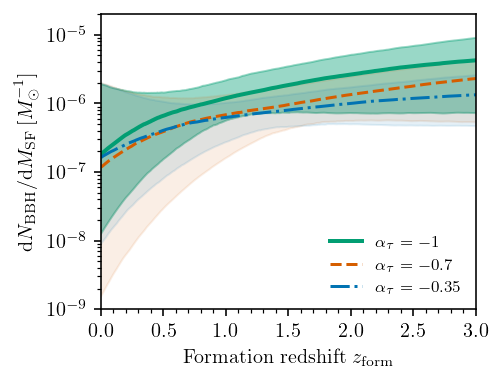

In [24]:
efficiency_default = Rfs / SFR_UV

efficiency_shallow = Rfs_al07 / SFR_UV

efficiency_shallower = Rfs_al035 / SFR_UV

fig, ax = plt.subplots(constrained_layout=True)

plot_helper.plot_bands(ax, xs, efficiency_default, bounds = [(5, 95)], plot_kwargs = dict(linewidth = 2.0, label = r'$\alpha_\tau = -1$'), alpha = 0.4, color = color_dict["default"])

plot_helper.plot_bands(ax, xs, efficiency_shallow, bounds = [(5, 95)], plot_kwargs = dict(linewidth = 1.5, label = r'$\alpha_\tau = -0.7$', ls = '--'), alpha = 0.1, color = color_dict["shallow"])

plot_helper.plot_bands(ax, xs, efficiency_shallower, bounds = [(5, 95)], plot_kwargs = dict(linewidth = 1.5, label = r'$\alpha_\tau = -0.35$', ls = '-.'), alpha = 0.1, color = color_dict["shallower"])



plt.legend(loc = 'lower right')

ax.set_yscale('log')

ax.set_xlim(0,3)

ax.set_ylim(1e-9, 2e-5)

ax.set_xlabel('Formation redshift $z_\mathrm{form}$')

ax.set_ylabel(r'$\mathrm{d}N_\mathrm{BBH}/ \mathrm{d}M_\mathrm{SF}\, [M_\odot^{-1}]$')

#plt.savefig('figures/formation_efficiency_v_redshift_different_tau.pdf', bbox_inches = 'tight')
#plt.savefig('figures/formation_efficiency_v_redshift_different_tau.png', bbox_inches = 'tight', dpi = 300)

In [25]:
print('default delay time, efficiency at z = 0', plot_helper.median_pm_symmetric(efficiency_default[:,0]*1e6))

z3_ind = np.arange(len(xs))[xs>=3][0]
print('default delay time, efficiency at z = 3', plot_helper.median_pm_symmetric(efficiency_default[:,z3_ind]*1e6))

default delay time, efficiency at z = 0 0.2^{+1.7}_{-0.2}
default delay time, efficiency at z = 3 4.3^{+4.8}_{-3.5}


alpha = -1: efficiency at z = 3 / z = 0 23.2^{+552.1}_{-22.8}
alpha = -0.35: efficiency at z = 3 / z = 0 8.5^{+228.2}_{-8.2}
alpha = -0.7: efficiency at z = 3 / z = 0 21.4^{+2145.3}_{-21.1}


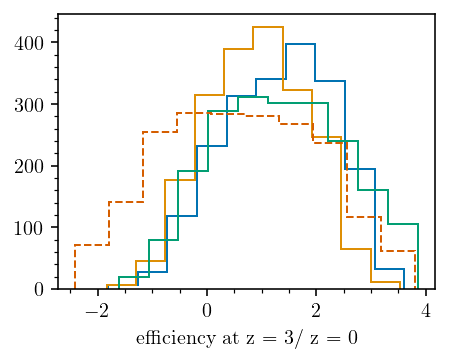

In [26]:
print('alpha = -1: efficiency at z = 3 / z = 0', plot_helper.median_pm_symmetric(efficiency_default[:,z3_ind]/efficiency_default[:,0]))

print('alpha = -0.35: efficiency at z = 3 / z = 0', plot_helper.median_pm_symmetric(efficiency_shallower[:,z3_ind]/efficiency_shallower[:,0]))

print('alpha = -0.7: efficiency at z = 3 / z = 0', plot_helper.median_pm_symmetric(efficiency_shallow[:,z3_ind]/efficiency_shallow[:,0]))

plt.hist(np.log10(efficiency_default[:,z3_ind]/efficiency_default[:,0]), histtype = 'step')
plt.hist(np.log10(efficiency_shallower[:,z3_ind]/efficiency_shallower[:,0]), histtype = 'step')
plt.hist(np.log10(efficiency_shallow[:,z3_ind]/efficiency_shallow[:,0]), histtype = 'step')
plt.hist(np.log10(efficiency_prior[:,z3_ind]/efficiency_prior[:,0]), histtype = 'step', ls = '--')
plt.xlabel('efficiency at z = 3/ z = 0')
plt.show()

### Metallicity evolution

#### assuming log-function BBH efficiency

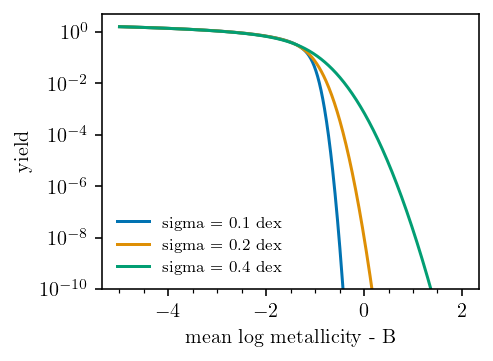

In [27]:
def yield_logZ(A, B, logZ):
    '''BBH yield as a function of log10 metallicity'''
    
    return np.where(logZ < (B - 1), A * np.log(B - logZ), 0)

def yield_muZ(A, BminusM, sig):
    '''BBH yield marginalized over distribution of metallicities
    as a function of parameter B - mean, where mean is the mean log10metallicity'''
    
    x = np.linspace(1, 10, 10000)
    
    integrand = np.exp(-(BminusM - x)**2/(2*sig**2)) * np.log(x)
    
    return A/(sig * (2*np.pi)**0.5) * np.trapz(integrand, x) 

BmM = np.linspace(-2, 5, 1000) #mu between roughly -4 < mu < 3, definitely within where we expect

sig = 0.1
yield_BmM_sig01 = np.array([yield_muZ(1, x, sig) for x in BmM]) #fixing A = 1
plt.plot(-BmM, yield_BmM_sig01, label = 'sigma = 0.1 dex') 

sig = 0.2
yield_BmM_sig02 = np.array([yield_muZ(1, x, sig) for x in BmM]) #fixing A = 1
plt.plot(-BmM, yield_BmM_sig02, label = 'sigma = 0.2 dex') 


sig = 0.4
yield_BmM_sig04 = np.array([yield_muZ(1, x, sig) for x in BmM]) #fixing A = 1
plt.plot(-BmM, yield_BmM_sig04, label = 'sigma = 0.4 dex') 

plt.yscale('log')
plt.ylabel('yield')
plt.xlabel('mean log metallicity - B')
plt.ylim(1e-10,5)

yield_BmMs = {'01' : yield_BmM_sig01, '02' : yield_BmM_sig02, '04' : yield_BmM_sig04}

plt.legend(loc = 'best')

def mean_metallicity_given_yield(A, B, eta, sig = '02'):
    
    
    BminusM = np.interp(eta / A, yield_BmMs[sig], BmM)
    
    mu = B - BminusM
    
    return mu

In [28]:
#from Chruślińska+ 2021 https://ui.adsabs.harvard.edu/abs/2021MNRAS.508.4994C/abstract, Fig 7 left and right panels.
#see https://ftp.science.ru.nl/astro/mchruslinska for data files.
with h5py.File("/Users/mayafishbach/Downloads/SFRD_Z_z_data/peakZ302f14SBBoco_FMR270_FOH_z_dM.dat.h5", "r") as inp:
    z_plot = np.array(inp["redshift"])
    peakZ_left = np.array(inp["peak_metallicity"])
    
with h5py.File("/Users/mayafishbach/Downloads/SFRD_Z_z_data/peakZ204f14SBBoco_FMR270_FOH_z_dM.dat.h5", "r") as inp:
    z_plot = np.array(inp["redshift"])
    peakZ_right = np.array(inp["peak_metallicity"])

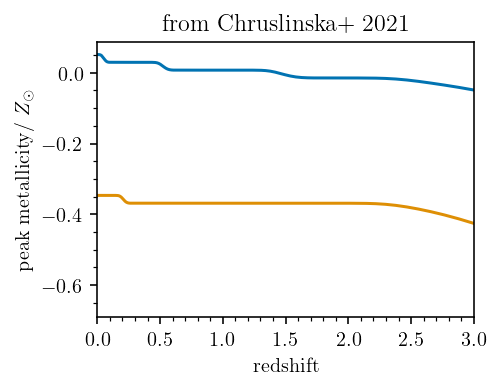

In [29]:
peakZ_Zsun_left = peakZ_left - 8.93 #converting to log10 solar metallicity assuming Grevesse & Sauval 1998 scale
peakZ_Zsun_right = peakZ_right - 8.93 


plt.plot(z_plot, peakZ_Zsun_left) 
plt.plot(z_plot, peakZ_Zsun_right) 
plt.xlabel('redshift')
plt.ylabel(r'peak metallicity/ $Z_\odot$')
plt.xlim(0,3)
plt.title('from Chruslinska+ 2021')
plt.show()

In [30]:
As = dict(medium = 3.5e-5, low = 1e-5, high = 6e-5) #medium, low and high efficiency
Bs = dict(medium = 0.85, low = 0.4, high = 1.3)

efficiencies = dict(default = efficiency_default, shallow = efficiency_shallow, shallower = efficiency_shallower) #default, shallow and shallower delay time dists
mean_Zs = dict(default = dict(), shallow = dict(), shallower = dict()) 

for key_tau in mean_Zs.keys():
    for key_Z in As.keys():
        mean_Zs[key_tau][key_Z] = mean_metallicity_given_yield(As[key_Z], Bs[key_Z], efficiencies[key_tau], sig = '02')

In [31]:
print('default delay time, mean log10 metallicity at z = 0', plot_helper.median_pm_symmetric(mean_Zs["default"]["medium"][:,0]))

z3_ind = np.arange(len(xs))[xs>=3][0]
print('default delay time, mean log10 metallicity at z = 3', plot_helper.median_pm_symmetric(mean_Zs["default"]["medium"][:,z3_ind]))


default delay time, mean log10 metallicity at z = 0 0.2^{+0.2}_{-0.3}
default delay time, mean log10 metallicity at z = 3 -0.2^{+0.3}_{-0.2}


In [32]:
print('alpha = -0.35 delay time, mean log10 metallicity at z = 0', plot_helper.median_pm_symmetric(mean_Zs["shallower"]["medium"][:,0]))

z3_ind = np.arange(len(xs))[xs>=3][0]
print('alpha = -0.35 delay time, mean log10 metallicity at z = 3', plot_helper.median_pm_symmetric(mean_Zs["shallower"]["medium"][:,z3_ind]))



alpha = -0.35 delay time, mean log10 metallicity at z = 0 0.2^{+0.2}_{-0.3}
alpha = -0.35 delay time, mean log10 metallicity at z = 3 -0.1^{+0.1}_{-0.1}


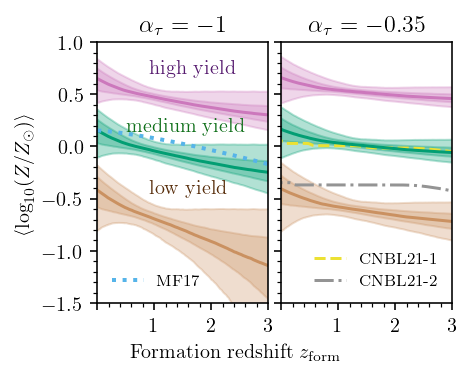

In [33]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, sharex = True, sharey = True)

cs = dict(medium = sns.color_palette()[2], low = sns.color_palette()[5], high = sns.color_palette()[4],
         default = sns.color_palette()[2], shallow = sns.color_palette()[3], shallower = sns.color_palette()[0])

cs_dark = dict(medium = sns.color_palette("dark")[2], low = sns.color_palette("dark")[5], high = sns.color_palette("dark")[4],
         default = sns.color_palette("dark")[2], shallow = sns.color_palette("dark")[3], shallower = sns.color_palette("dark")[0])

labels = dict(medium = 'medium yield', low = 'low yield', high = 'high yield',
             default = r'$\alpha_\tau = -1$', shallow = r'$\alpha_\tau = -0.5$', shallower = r'$\alpha_\tau = -0.25$')

for key_Z in As.keys():
    plot_helper.plot_bands(ax[0], xs, mean_Zs["default"][key_Z], color = cs[key_Z])


logZ_of_z_mean = 0.153 - 0.074 * xs**1.34 #logmean metallicity as a function of redshift from Madau & Fragos 2017

ax[0].plot(xs, logZ_of_z_mean, ls = ':', linewidth = 2.0, color = sns.color_palette()[9], label = 'MF17')
ax[1].plot(z_plot, peakZ_Zsun_left, ls = '--', color = sns.color_palette()[8], label = 'CNBL21-1') 
ax[1].plot(z_plot, peakZ_Zsun_right, ls = '-.', color = sns.color_palette()[7], label = 'CNBL21-2') 




ax[0].set_xlim(0,3)
ax[0].set_ylim(-1.5, 1)

#ax[0].set_xlabel('Formation redshift $z_\mathrm{form}$')
ax[0].set_ylabel(r'$\langle \log_{10}(Z/Z_\odot) \rangle$') 

ax[0].set_title(r'$\alpha_\tau = -1$')

ax[1].set_title(r'$\alpha_\tau = -0.35$')

for key_Z in As.keys():
    plot_helper.plot_bands(ax[1], xs, mean_Zs["shallower"][key_Z], color = cs[key_Z])


ax[0].annotate(text = "high yield", xy = (0.9, 0.7), color = cs_dark["high"])
ax[0].annotate(text = "medium yield", xy = (0.5, 0.15), color = cs_dark["medium"])
ax[0].annotate(text = "low yield", xy = (0.9, -0.45), color = cs_dark["low"])

ax[0].legend(loc = 'lower left')
ax[1].legend(loc = 'lower right')

ax[1].set_xticks([0,1,2,3], labels = ['','1','2','3'])

fig.text(0.5, -0.001, 'Formation redshift $z_\mathrm{form}$', ha = 'center')

plt.tight_layout(w_pad = 0.05)

#plt.savefig("figures/meanZvz_2panel.pdf", bbox_inches = 'tight')
#plt.savefig("figures/meanZvz_2panel.png", dpi = 300, bbox_inches = 'tight')